## Augmentations

Now that we're using Albumentations Augmentations we should play around with a few of them.

To start we'll import a few libraries and setup some helper code to look at different augmentations.

In [19]:
import os
import cv2
import numpy as np
import pandas as pd
import albumentations as albu

import matplotlib.pyplot as plt


In [44]:
def get_img(x, folder: str='train_images'):
    """
    Return image based on image name and folder.
    """
    data_folder = f"{path}/{folder}"
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')


def make_mask(df: pd.DataFrame, image_name: str='img.jpg', shape: tuple = (1400, 2100)):
    """
    Create mask based on df, image name and shape.
    """
    encoded_masks = df.loc[df['im_id'] == image_name, 'EncodedPixels']
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)

    for idx, label in enumerate(encoded_masks.values):
        if label is not np.nan:
            mask = rle_decode(label)
            masks[:, :, idx] = mask
            
    return masks

def mask2rle(img):
    '''
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def visualize(image, mask, original_image=None, original_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 16))

        ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].set_title(f'Mask {class_dict[i]}', fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 6))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
                
        for i in range(4):
            ax[0, i + 1].imshow(original_mask[:, :, i])
            ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)
        
        ax[1, 0].imshow(image)
        ax[1, 0].set_title('Transformed image', fontsize=fontsize)
        
        
        for i in range(4):
            ax[1, i + 1].imshow(mask[:, :, i])
            ax[1, i + 1].set_title(f'Transformed mask {class_dict[i]}', fontsize=fontsize)
            
            
def visualize_with_raw(image, mask, original_image=None, original_mask=None, raw_image=None, raw_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}

    f, ax = plt.subplots(3, 5, figsize=(24, 12))

    ax[0, 0].imshow(original_image)
    ax[0, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[0, i + 1].imshow(original_mask[:, :, i])
        ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)


    ax[1, 0].imshow(raw_image)
    ax[1, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[1, i + 1].imshow(raw_mask[:, :, i])
        ax[1, i + 1].set_title(f'Raw predicted mask {class_dict[i]}', fontsize=fontsize)
        
    ax[2, 0].imshow(image)
    ax[2, 0].set_title('Transformed image', fontsize=fontsize)


    for i in range(4):
        ax[2, i + 1].imshow(mask[:, :, i])
        ax[2, i + 1].set_title(f'Predicted mask with processing {class_dict[i]}', fontsize=fontsize)
            
            
def plot_with_augmentation(image, mask, augment):
    """
    Wrapper for `visualize` function.
    """
    augmented = augment(image=image, mask=mask)
    image_flipped = augmented['image']
    mask_flipped = augmented['mask']
    visualize(image_flipped, mask_flipped, original_image=image, original_mask=mask)
    
    
sigmoid = lambda x: 1 / (1 + np.exp(-x))


def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    # don't remember where I saw it
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num


def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0),
        albu.GridDistortion(p=0.5),
        albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
        albu.Resize(352, 544)
    ]
    return albu.Compose(train_transform)

In [45]:
path = 'data'
train = pd.read_csv(f'{path}/train.csv')
sub = pd.read_csv(f'{path}/sample_submission.csv')

In [46]:
train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
train['im_id'] = train['Image_Label'].apply(lambda x: x.split('_')[0])

sub['label'] = sub['Image_Label'].apply(lambda x: x.split('_')[1])
sub['im_id'] = sub['Image_Label'].apply(lambda x: x.split('_')[0])

In [47]:
image_name = '8242ba0.jpg'
image = get_img(image_name)
mask = make_mask(train, image_name)

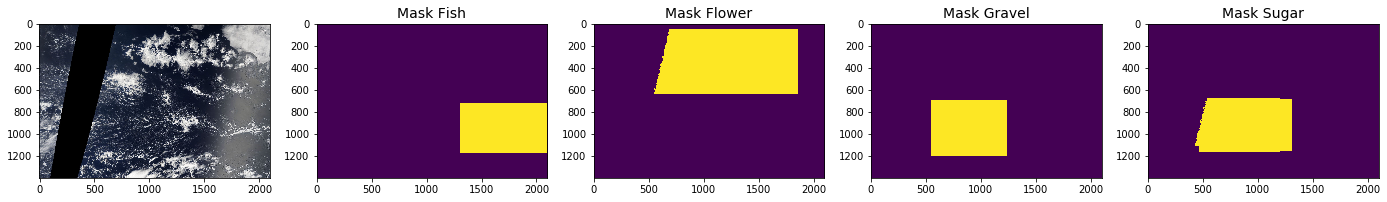

In [48]:
visualize(image, mask)

### Horizontal Flip

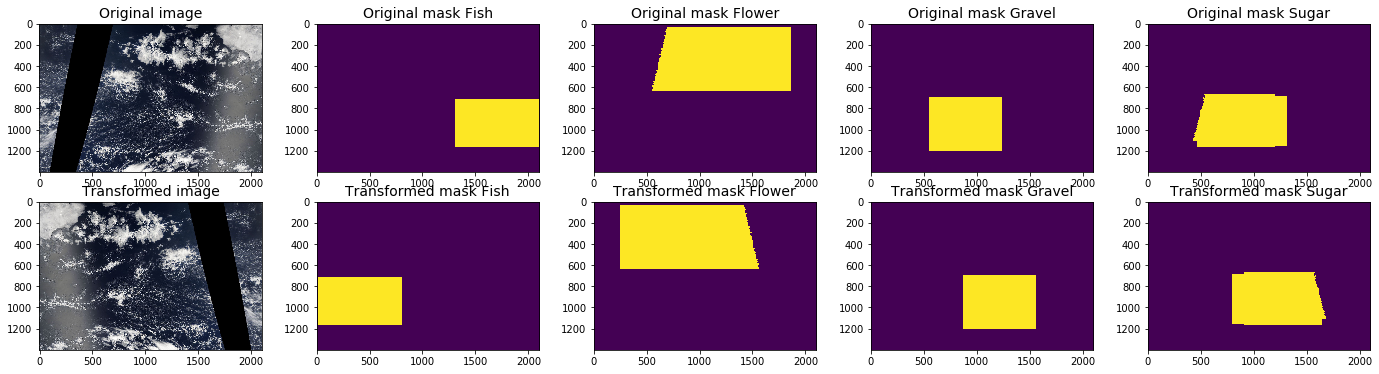

In [134]:
plot_with_augmentation(image, mask, albu.HorizontalFlip(p=1))

### ShiftScaleRotate

This is the default choice provided by the network. It has no rotation and occasionally zooms in/out too far.

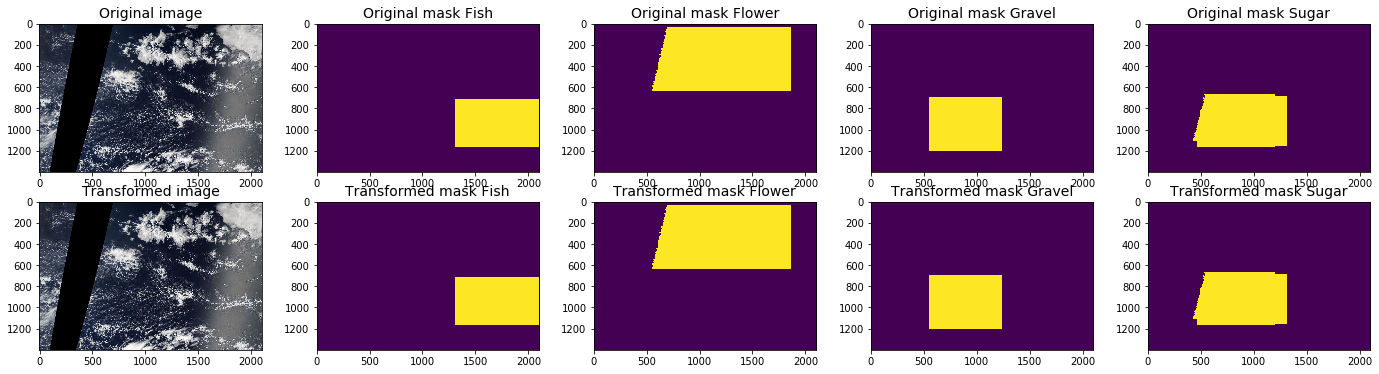

In [146]:
tfm = albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0)
plot_with_augmentation(image, mask, tfm)

Here's my adjusted approach. We only zoom in slightly and we rotate the image.

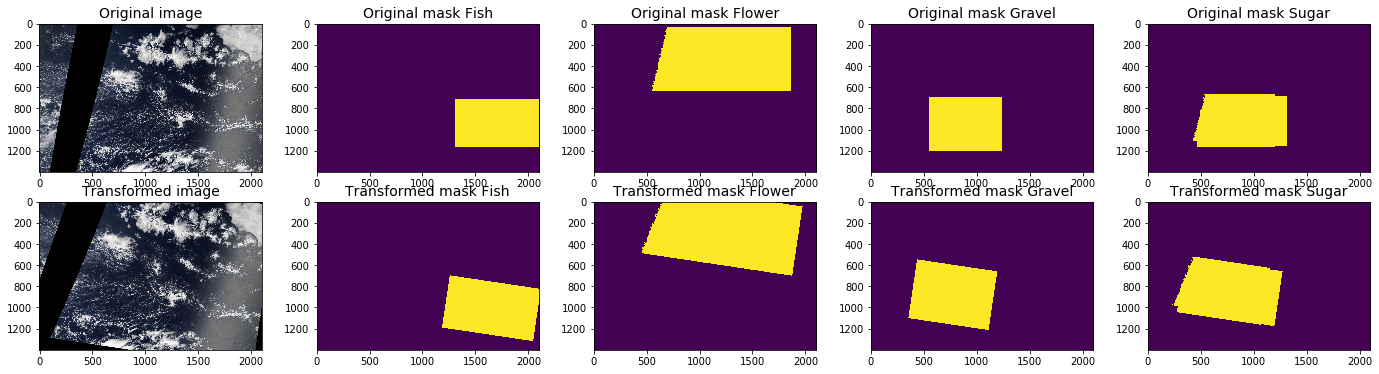

In [147]:
tfm = albu.ShiftScaleRotate(scale_limit=(0.1, 0.1), rotate_limit=45, p=1.0, border_mode=0)
plot_with_augmentation(image, mask, tfm)

### Grid Distortion

Hard to tell what this one does, but presumably it moves the pixels around a little bit.

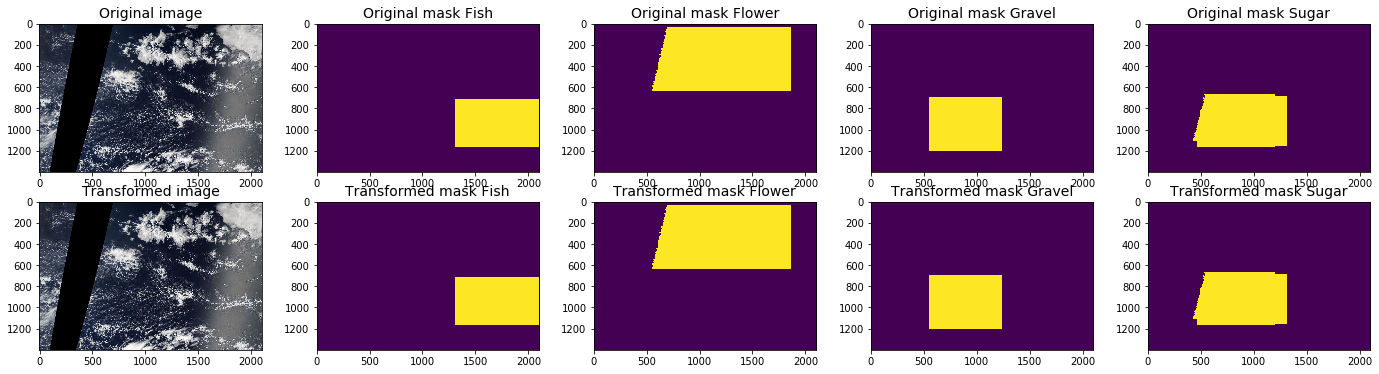

In [152]:
tfm = albu.GridDistortion(p=0.5)
plot_with_augmentation(image, mask, tfm)

### Optical Distortion

I don't really like this one very much. It ends up warping the masks much more than I'd like.

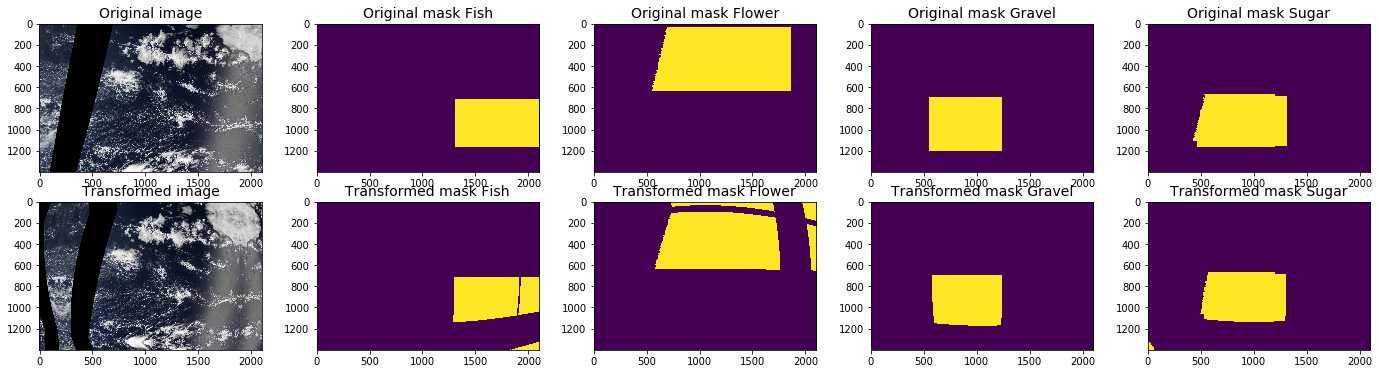

In [170]:
tfm = albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5)
plot_with_augmentation(image, mask, tfm)

## Additional Augmenations

### Random Contrast

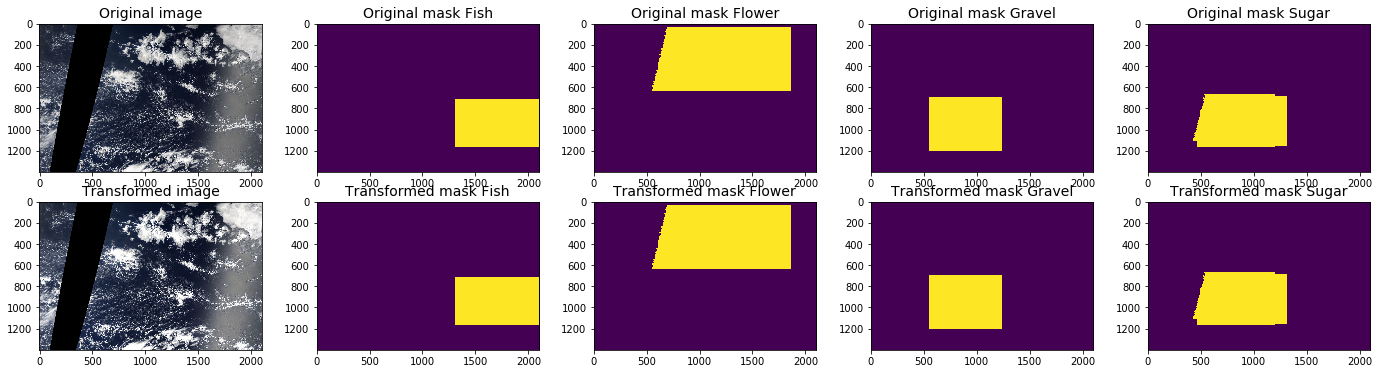

In [229]:
tfm = albu.RandomContrast(limit=0.3, p=1)
plot_with_augmentation(image, mask, tfm)

## RandomBrightness

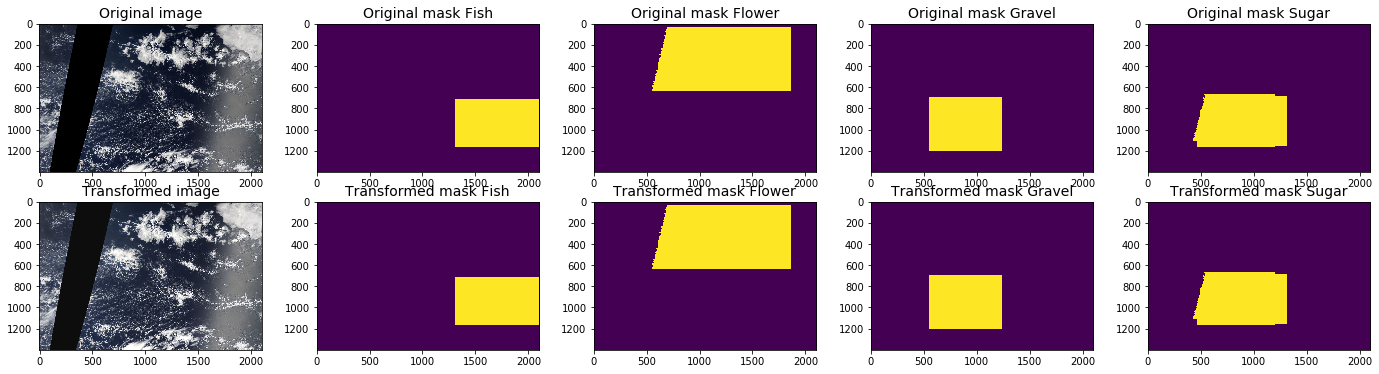

In [194]:
tfm = albu.RandomBrightness(limit=0.3, p=1)
plot_with_augmentation(image, mask, tfm)

### CropNonEmptyMaskIfExists

This is an interesting one. We can make it so it always crops an area that contains a label. This would be useful to use in conjunction with another random crop. We could control exactly how many crops we wanted to contain labels and how many could contain empty space.

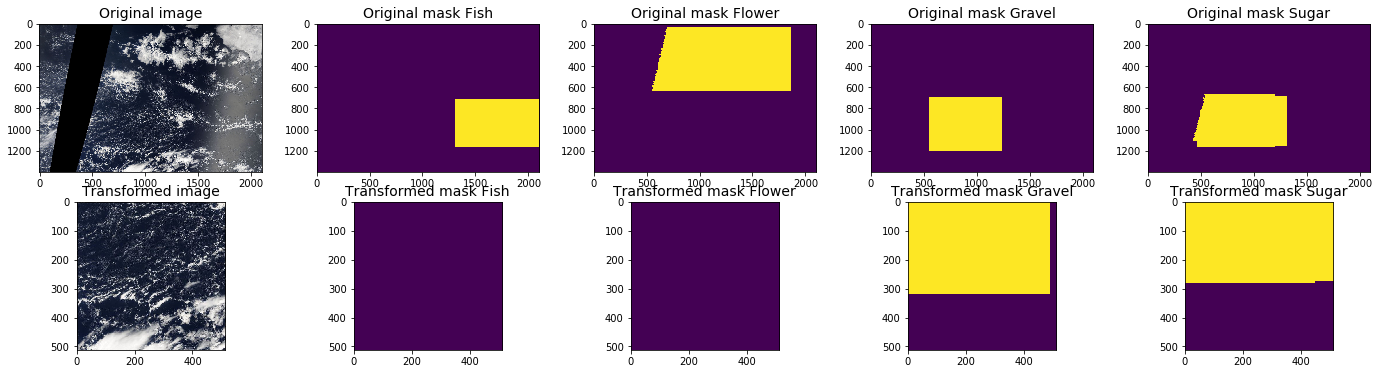

In [201]:
tfm = albu.CropNonEmptyMaskIfExists(512, 512)
plot_with_augmentation(image, mask, tfm)

### Random Crop

This is just a standard random crop.

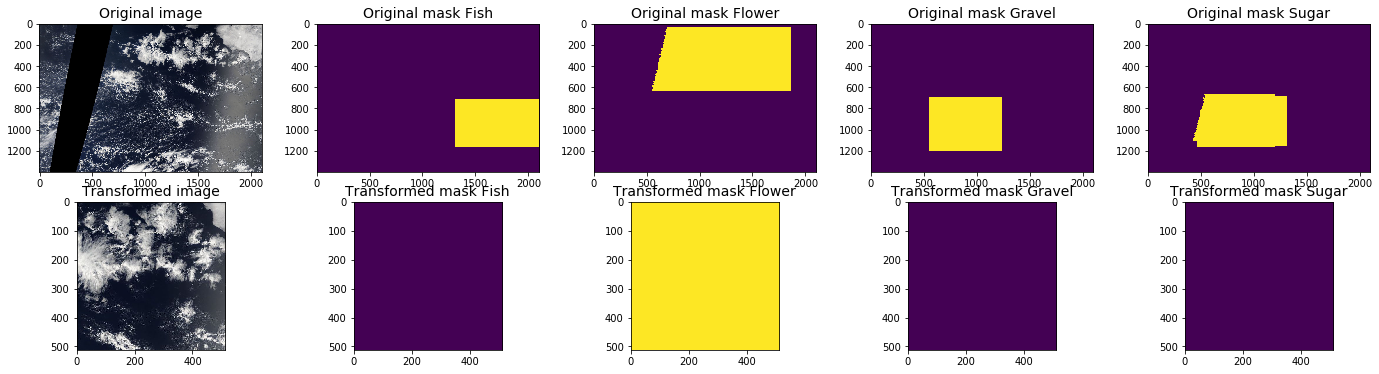

In [215]:
tfm = albu.RandomCrop(512, 512)
plot_with_augmentation(image, mask, tfm)

## Cutout

Unfortunately cutout doesn't seem to work on labels...

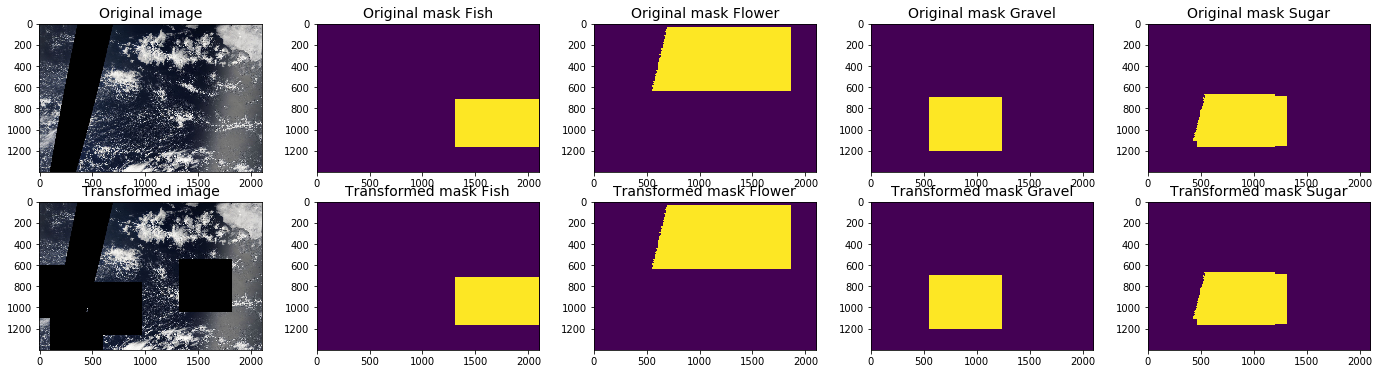

In [219]:
tfm = albu.Cutout(num_holes=4, max_h_size=500, max_w_size=500)
plot_with_augmentation(image, mask, tfm)

## New Augmentations

Let's stick the augmentations we'd like together. We'll randomly flip, rotate distort and contrast the image before cropping it.

In [ ]:
tfm = albu.ShiftScaleRotate(scale_limit=(0.1, 0.1), rotate_limit=45, p=0.5, border_mode=0)
plot_with_augmentation(image, mask, tfm)

In [223]:
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=(0.1, 0.1), rotate_limit=45, p=0.5, border_mode=0),
        albu.GridDistortion(p=0.5),
        albu.RandomContrast(limit=0.3, p=0.5),
        albu.OneOf([
            albu.RandomCrop(512, 512),
            albu.CropNonEmptyMaskIfExists(512, 512)
        ])
    ]

    return albu.Compose(train_transform)

In [224]:
get_training_augmentation()

Compose([
  HorizontalFlip(always_apply=False, p=0.5),
  VerticalFlip(always_apply=False, p=0.5),
  ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(-0.0625, 0.0625), scale_limit=(0.10000000000000009, 0.10000000000000009), rotate_limit=(-45, 45), interpolation=1, border_mode=0, value=None, mask_value=None),
  GridDistortion(always_apply=False, p=0.5, num_steps=5, distort_limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None),
  OneOf([
    RandomCrop(always_apply=False, p=1.0, height=512, width=512),
    CropNonEmptyMaskIfExists(always_apply=False, p=1.0, height=512, width=512, ignore_values=None, ignore_channels=None),
  ], p=0.5),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})